GPU availability: True; automation will be using: cuda:0 (32, 3, 256, 256)
(32, 18, 32, 32)
(32, 1, 256, 256)


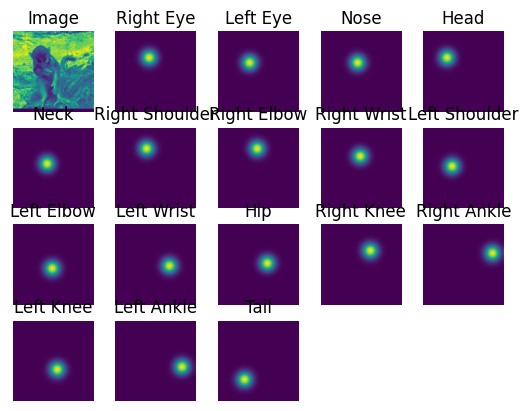

In [57]:
from matplotlib.transforms import ScaledTranslation
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import torch.nn.functional as F 
import os
import json
from tqdm import tqdm
# from google.colab import drive
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import math
import cv2
import skimage.filters as filters
import skimage.transform as transform
import sys
np.set_printoptions(threshold=sys.maxsize)

#Set device to GPU if possible
cuda = torch.cuda.is_available()
device = 'cuda:0' if cuda else 'cpu'

#print(cuda)
print("GPU availability: {}; automation will be using: {} ".format(cuda, device), end= '')

#Path to where data is stored
# drive.mount('/content/gdrive/', force_remount = True)
dir_path = "."

#Set automation to Train or Test
Train = False

def Load_Data():

  if(Train == True):
    dir = os.path.join(dir_path, "train_annotation.json")
  else:
    dir = os.path.join(dir_path, "val_annotation.json")

  with open(dir) as f:
      dictionary = json.load(f)
      feature_list = [item for item in dictionary['data']]
      feature_list = np.asarray(feature_list)

  return(feature_list)

def get_image(feature_list, index):

  if(Train == True):
    dir_image_folder = os.path.join(dir_path, "train")
  else:
    dir_image_folder = os.path.join(dir_path, "val")
    
  # print("dir_image_folder: ",dir_image_folder)

  feature = feature_list[index]

  dir_image = os.path.join(dir_image_folder, feature["file"])

  img = mpimg.imread(dir_image)

  #plt.imshow(img)

  return img

#Return batches with image filepaths. Will need to "get_image" by batch as
#RAM capacity is surpassed if we attempt to get all images within the create batch
#method.

def create_batches(data, batch_size):

  data_count = len(data)
  index_array = random.sample(range(0, data_count), data_count)

  mini_batch_count = math.floor(data_count/batch_size)

  mini_batch_x = []

  for batch in range(int(mini_batch_count)):
    batch_x = []
    try:
      for value in range(batch_size):
        batch_x.append(index_array[value + batch * batch_size])
      batch_x = np.asarray(batch_x)
      mini_batch_x.append(batch_x)
    except:
      batch_x = np.asarray(batch_x)
      mini_batch_x.append(batch_x)
  mini_batch_x = np.asarray(mini_batch_x)
  return mini_batch_x
#torch_data.dataloader(data_class, batch_size = 1, shuffle = True)

def get_batch_data(data, batch, size):
  batch_data_train_images = []
  batch_data_heat_maps = []
  batch_data_center_heat_map = []

  heat_map_size = (32, 32)
  center_map_size = (256, 256)

  for value in range(len(batch)):
    # print(batch[value])
    img = get_image(data, batch[value])
    cropped_image, cropped_joints, cropped_center = crop_image(img, data[batch[value]], size)
    #Create ground truth heatmap and center heat map
    heat_maps, center_heat_map = get_heatmap([np.zeros(heat_map_size), np.zeros(center_map_size)], cropped_joints/8, cropped_center)
    train_image = np.transpose(cropped_image, (2, 0, 1))/255.0
    batch_data_train_images.append(train_image)
    batch_data_heat_maps.append(heat_maps)
    batch_data_center_heat_map.append(center_heat_map)

  batch_data_train_images = np.asarray(batch_data_train_images)
  batch_data_heat_maps = np.asarray(batch_data_heat_maps)
  batch_data_center_heat_map = np.asarray(batch_data_center_heat_map)

  return batch_data_train_images, batch_data_heat_maps, batch_data_center_heat_map

def crop_image(img, features, image_size):
  joint_points = features["landmarks"]
  bbox = features["bbox"]
  visibility = np.asarray(features["visibility"])

  x = []
  y = []

  for value in range(0, len(joint_points), 2):
    x.append(joint_points[value])
  width_points = np.transpose(np.asarray(x))

  for value in range(1, len(joint_points), 2):
    y.append(joint_points[value])
  height_points = np.transpose(np.asarray(y))

  Height, Width = img.shape[0], img.shape[1]

  bbox_x1 = math.floor(bbox[0])
  bbox_x2 = math.floor(bbox[0] + bbox[2])
  bbox_y1 = math.floor(bbox[1])
  bbox_y2 = math.floor(bbox[1] + bbox[3])

  cropped_x = bbox_x2 - bbox_x1
  cropped_y = bbox_y2 - bbox_y1

  if(cropped_y > cropped_x):
    cropped_difference = cropped_y - cropped_x
    bbox_x1 = bbox_x1 - math.floor(cropped_difference/2)
    bbox_x2 = bbox_x2 + math.floor(cropped_difference/2)
  elif(cropped_x > cropped_y):
    cropped_difference = cropped_x - cropped_y
    bbox_y1 = bbox_y1 - math.floor(cropped_difference/2)
    bbox_y2 = bbox_y2 + math.floor(cropped_difference/2)

  #Sift our Width and Height points for any zero values
  width_points = np.where(width_points != 0, width_points - bbox_x1, width_points)
  height_points = np.where(height_points != 0, height_points - bbox_y1, height_points)

  #Determine if padding is needed for image
  padding = 0

  if((bbox_y1 < 0) or (bbox_x1 < 0) or (bbox_y2 > Height) or (bbox_x2 > Width)):
    padding = math.floor(max(-bbox_y1, -bbox_x1, bbox_y2 - Height, bbox_x2 - Width))
    img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)))

  img = img[bbox_y1 + padding : bbox_y2 + padding, bbox_x1 + padding : bbox_x2 + padding]

  bbox[0] = bbox[0] - bbox_x1
  bbox[1] = bbox[1] - bbox_y1

  #Resize our image
  Height, Width = img.shape[0], img.shape[1]
  width_points = (width_points * image_size)/Width
  height_points = (height_points * image_size)/Width

  center = np.array((1, 2))

  center[0] = (abs(math.floor((bbox_x2 - bbox_x1)/2))) * (image_size/Width)
  center[1] = (abs(math.floor((bbox_y2 - bbox_y1)/2))) * (image_size/Height)

  img = cv2.resize(img, (image_size, image_size))

  joint_points = [[width_points[i], height_points[i]] for i in range(len(height_points))]

  return img, np.asarray(joint_points), np.asarray(center)

def get_heatmap(img, joint_points, cropped_center):
  heat_map_size = img[0]
  #print(heat_map_size.shape)
  Height, Width = heat_map_size.shape[0], heat_map_size.shape[1]
  #print(joint_points.shape)

  #Build shell for heatmap of each joint_point
  heat_maps = np.zeros((Height, Width, (len(joint_points) + 1)))

  for joint in range(len(joint_points)):
    if((joint_points[joint, 0] == 0) and (joint_points[joint, 1] == 0)):
      continue

    if(joint_points[joint, 1] >= Height):
      joint_points[joint, 1] = Height - 1
    if(joint_points[joint, 0] >= Width):
      joint_points[joint, 0] = Width - 1
    
    #Build heatmap of joint
    heat_map = heat_maps[:, :, joint]
    x = math.floor(joint_points[joint, 1])
    y = math.floor(joint_points[joint, 0])

    #Set heatmap of joint within heatmap image
    heat_map[x][y] = 1
    heat_map = filters.gaussian(heat_map, sigma = 2)

    #scale image to [0, 1]
    scale = np.max(heat_map)
    heat_map = heat_map/scale
    heat_maps[:, :, joint] = heat_map

  #add background dimensions
  heat_maps[:, :, len(joint_points)] = 1 - np.max(heat_maps[:, :, :len(joint_points)], axis = 2)
  heat_maps = np.transpose(heat_maps, (2, 0, 1))


  #Center image
  center_heat_map = img[1] #256x256

  Height, Width = center_heat_map.shape[0], center_heat_map.shape[1]
  x = math.floor(cropped_center[1]); y = math.floor(cropped_center[0])
  center_heat_map[x][y] = 1

  center_heat_map = filters.gaussian(center_heat_map, sigma = 2)
  scale = np.max(center_heat_map)
  center_heat_map = center_heat_map/scale
  center_heat_map = np.expand_dims(center_heat_map, axis = 0)
  #print(center_heat_map.shape)
  return heat_maps, center_heat_map

def view_heat_maps(img, heat_maps):
  Height, Width = img.shape[0], img.shape[1]

  heat_maps = np.transpose(heat_maps)

  dictionary_of_names = {0: 'Image', 1: 'Right Eye', 2: 'Left Eye', 3: 'Nose', 4: 'Head',
    5: 'Neck', 6: 'Right Shoulder', 7: 'Right Elbow', 8: 'Right Wrist', 9: 'Left Shoulder',
    10: 'Left Elbow', 11: 'Left Wrist', 12: 'Hip', 13: 'Right Knee', 14: 'Right Ankle',
    15: 'Left Knee', 16: 'Left Ankle', 17: 'Tail'}

  #print(heat_maps.shape)
  if(heat_maps.shape[0] != Height):
    heat_maps = transform.resize(heat_maps, (Height, Width))
  elif(heat_maps.shape[1] != Width):
    heat_maps = transform.resize(heat_maps, (Height, Width))

  for value in range((heat_maps.shape[2])): #256x256x18
    #print(value)
    plt.subplot(4, 5, value + 1)
    plt.title(dictionary_of_names[value], fontdict = {"fontsize" : 12})
    plt.axis("off")

    if value == 0:
      plt.imshow(img)
    else:
      plt.imshow(heat_maps[:, :, value - 1])
  plt.show()


if __name__ == '__main__':
  #Config
  crop_size = 256
  batch_size = 32

  #Load in the data for training and/or validation
  data = Load_Data()

  #Create batches containing unique indexes expanding the length of our training set
  batches_x = create_batches(data, batch_size)

  #Grab the images from each batch containing unique indexes of training data
  train_images_batch, heat_images_batch, center_image_batch = get_batch_data(data, batches_x[0], crop_size)

  print(train_images_batch.shape) # (batch size, channels, height, width)
  print(heat_images_batch.shape)
  print(center_image_batch.shape)
  #print(center_image_batch[0][0])


  view_heat_maps(train_images_batch[0][0], heat_images_batch[0])


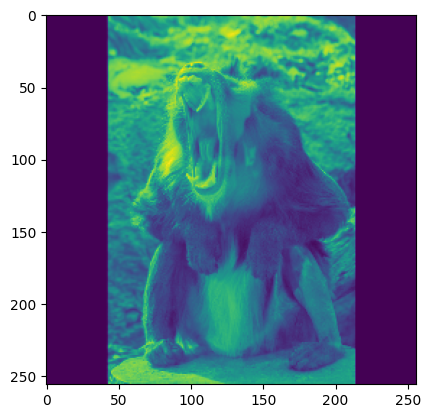

In [58]:
#from google.colab import drive
#drive.mount('/content/drive')
plt.imshow(train_images_batch[4, 0])

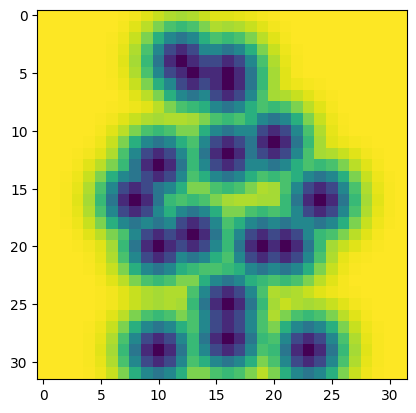

In [59]:
plt.imshow(heat_images_batch[4, 17])

# CPM

In [60]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import torch.nn.functional as F 

class CPM(nn.Module): # CPM model inherits nn.Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self, num_joints):
    super(CPM, self).__init__()
    self.num_joints = num_joints

    self.cpool = nn.AvgPool2d(8)                               # avg pool operation with kernel size 8 for center_image

    # To extract features (x) for every stage
    self.x_conv1 = nn.Conv2d(3, 128, 9, padding=4)             # (input channels, output channels, kernel size, padding) // output channels = number of kernels used on image, might be good to play around with values
    self.x_pool1 = nn.MaxPool2d(2)                             # max pool operation with kernel size 2
    self.x_conv2 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool2 = nn.MaxPool2d(2)                 
    self.x_conv3 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool3 = nn.MaxPool2d(2)
    self.x_conv4 = nn.Conv2d(128, 32, 5, padding=2)  

    # Stage 1 convolutions:
    self.s1_conv1 = nn.Conv2d(32, 512, 9, padding=4)
    self.s1_conv2 = nn.Conv2d(512, 512, 1)
    self.s1_conv3 = nn.Conv2d(512, num_joints+1, 1)

    # Stage >= 2 (t) convolutions:
    self.st_conv1 = nn.Conv2d(34 + num_joints, 128, 11, padding=5)  # input channels = output channels from image features (x) + output channels from previous stage + 1 channel for loss
    self.st_conv2 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv3 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv4 = nn.Conv2d(128, 128, 1)
    self.st_conv5 = nn.Conv2d(128, num_joints + 1, 1)

  def extract_features(self, im):                                   # input im shape = (N, 3, H, W) // output shape = (N, 32, H/8, W/8)    N = batch size
    x = self.x_pool1(F.relu(self.x_conv1(im)))
    x = self.x_pool2(F.relu(self.x_conv2(x)))
    x = self.x_pool3(F.relu(self.x_conv3(x)))
    return F.relu(self.x_conv4(x))
  
  def stage_1(self, x):                                             # input x shape = (N, 32, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.s1_conv1(x))
    x = F.relu(self.s1_conv2(x))
    return F.relu(self.s1_conv3(x))

  def stage_t(self, x):                                             # input x shape = (N, 34 + num_joints, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.st_conv1(x))
    x = F.relu(self.st_conv2(x))
    x = F.relu(self.st_conv3(x))
    x = F.relu(self.st_conv4(x))
    return F.relu(self.st_conv5(x))
  
  def forward(self, im, center_image): # for 6 stages
    cpool = self.cpool(center_image)

    s1_maps = self.stage_1(self.extract_features(im))
    x = self.extract_features(im)
    s2_maps = self.stage_t(torch.cat([x, s1_maps, cpool], dim=1))
    s3_maps = self.stage_t(torch.cat([x, s2_maps, cpool], dim=1))
    s4_maps = self.stage_t(torch.cat([x, s3_maps, cpool], dim=1))
    s5_maps = self.stage_t(torch.cat([x, s4_maps, cpool], dim=1))
    s6_maps = self.stage_t(torch.cat([x, s5_maps, cpool], dim=1))

    return torch.stack([s1_maps, s2_maps, s3_maps, s4_maps, s5_maps, s6_maps], dim=1)

In [61]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

cuda = torch.cuda.is_available()
device = 'cuda:0' if cuda else 'cpu'
dir = os.path.join(dir_path, "cpm_baseline.pth")

epochs = 500
lr = 0.0001
model = CPM(17).to(device)
batch_size = 32

class TrainData(Dataset):
    def __init__(self):
        super(TrainData, self).__init__()
        dir = os.path.join(dir_path, 'train_annotation.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'train', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        hm_size = (32, 32)
        cm_size = (256, 256)

        c_im, c_jts, c_cen = crop_image(im, f_d, crop_size)
        hmaps, cmap = get_heatmap([np.zeros(hm_size), np.zeros(cm_size)], c_jts/8, c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, hmaps, cmap

    def __len__(self):
        return len(self.features)

def train():
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(lr = lr)
  loss_array = []
  model.train()

  model.load_state_dict(torch.load(dir))

  train_data = DataLoader(TrainData(), batch_size=batch_size, shuffle=True, num_workers=4)

  for epoch in range(epochs):
    if(epoch % 2 == 0 and epoch != 0):
      torch.save(model.state_dict(), dir)
      print("Saving Model.")
    for i, (im, heat, center) in tqdm(enumerate(train_data)):
      
      im = im.float().to(device)
      heat = torch.stack([heat]*6, dim=1) # stack one set of heatmaps for each stage of our CPM
      heat = heat.float().to(device)
      center = center.float().to(device)

      pred = model(im, center)
      loss = criterion(pred, heat)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #print('----------------- Epoch ' + str(epoch + 1) + ', batch ' + str(i + 1) + '/' + str(len(train_data)) + ', Loss: ' + str(loss.item()) + ' -----------------')
      # for j in range(batches.shape[1]):
      #   im = torch.FloatTensor(im_batch[j]).to(device)
      #   heat = torch.FloatTensor(heat_batch[j]).to(device)
      #   center = torch.FloatTensor(center_batch[j]).to(device)
      if(i % 200 == 0):
        print(loss.item())
    loss_array.append(loss)
    print(loss)
    
  #Save model one final time
  torch.save(model.state_dict(), dir)

In [62]:
from torch.utils.data import DataLoader

cuda = torch.cuda.is_available()
# device = 'cuda:0' if cuda else 'cpu'
# dir = os.path.join(dir_path, "cpm_baseline.pth")

epochs = 500
lr = 0.001
model = CPM(17).to(device)
batch_size = 32

def train():
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  loss_array = []
  model.train()

  train_data = DataLoader(TrainData(), batch_size=batch_size, shuffle=True, num_workers=4)

  for epoch in range(epochs):
    if(epoch % 20 == 0):
      torch.save(model.state_dict(), dir)
      print("Saving Model.")
    for i, (im, heat, center) in enumerate(train_data):
      
      im = im.float().to(device)
      heat = torch.stack([heat]*6, dim=1) # stack one set of heatmaps for each stage of our CPM
      heat = heat.float().to(device)
      center = center.float().to(device)

      # print("heat.shape: ", heat.shape)
      # heat = heat.astype(np.uint8)
      # heat = np.asarray([cv2.resize(heat1, (256,256)) for heat1 in heat])
      # heat.resize_(32, 6, 18, 256, 256)
      # print("heat.shape: ", heat.shape)

      pred = model(im, center)
      # print("pred.shape: ",pred.shape)

      loss = criterion(pred, heat)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print('----------------- Epoch ' + str(epoch + 1) + ', batch ' + str(i + 1) + '/' + str(len(train_data)) + ', Loss: ' + str(loss.item()) + ' -----------------')
      # for j in range(batches.shape[1]):
      #   im = torch.FloatTensor(im_batch[j]).to(device)
      #   heat = torch.FloatTensor(heat_batch[j]).to(device)
      #   center = torch.FloatTensor(center_batch[j]).to(device)
    loss_array.append(loss)
    
  #Save model one final time
  torch.save(model.state_dict(), dir)

In [63]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
def crop_image_test(img, features, image_size): #crop_image function for testing-relevant features

  bbox = features["bbox"]
  bb = bbox.copy()

  Height, Width = img.shape[0], img.shape[1]

  bbox_x1 = math.floor(bbox[0])
  bbox_x2 = math.floor(bbox[0] + bbox[2])
  bbox_y1 = math.floor(bbox[1])
  bbox_y2 = math.floor(bbox[1] + bbox[3])

  cropped_x = bbox_x2 - bbox_x1
  cropped_y = bbox_y2 - bbox_y1

  if(cropped_y > cropped_x):
    cropped_difference = cropped_y - cropped_x
    bbox_x1 = bbox_x1 - math.floor(cropped_difference/2)
    bbox_x2 = bbox_x2 + math.floor(cropped_difference/2)
  elif(cropped_x > cropped_y):
    cropped_difference = cropped_x - cropped_y
    bbox_y1 = bbox_y1 - math.floor(cropped_difference/2)
    bbox_y2 = bbox_y2 + math.floor(cropped_difference/2)

  #Determine if padding is needed for image
  padding = 0

  if((bbox_y1 < 0) or (bbox_x1 < 0) or (bbox_y2 > Height) or (bbox_x2 > Width)):
    padding = math.floor(max(-bbox_y1, -bbox_x1, bbox_y2 - Height, bbox_x2 - Width))
    img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)))

  img = img[bbox_y1 + padding : bbox_y2 + padding, bbox_x1 + padding : bbox_x2 + padding]

  bbox[0] = bbox[0] - bbox_x1
  bbox[1] = bbox[1] - bbox_y1

  #Resize our image
  Height, Width = img.shape[0], img.shape[1]

  center = np.array((1, 2))

  center[0] = (abs(math.floor((bbox_x2 - bbox_x1)/2))) * (image_size/Width)
  center[1] = (abs(math.floor((bbox_y2 - bbox_y1)/2))) * (image_size/Height)

  img = cv2.resize(img, (image_size, image_size))

  return img, np.asarray(center), bb

def get_cmap(img, cropped_center):
  #Center image
  center_heat_map = img #256x256

  Height, Width = center_heat_map.shape[0], center_heat_map.shape[1]
  x = math.floor(cropped_center[1]); y = math.floor(cropped_center[0])
  center_heat_map[x][y] = 1

  center_heat_map = filters.gaussian(center_heat_map, sigma = 2)
  scale = np.max(center_heat_map)
  center_heat_map = center_heat_map/scale
  center_heat_map = np.expand_dims(center_heat_map, axis = 0)
  #print(center_heat_map.shape)
  return center_heat_map

def get_landmarks(pred, bb): # pred is predicted heat map, bb is bounding box from json
  landmarks = []
  h, w = (bb[3], bb[2])  # (h, w)

  if h > w:
    scale = h / pred.shape[1]
    offset = np.array([0, (h-w)//2])
  else:
    scale = w / pred.shape[1]
    offset = np.array([(w-h)//2, 0])

  for i in range(17): #num_joints
    y, x = np.unravel_index(np.argmax(pred[i,:,:]), (pred.shape[1], pred.shape[2]))

    y = y * scale - offset[0] + bb[1]
    x = x * scale - offset[1] + bb[0]
    
    landmarks.append(int(x))
    landmarks.append(int(y))
  
  return landmarks

class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()
        dir = os.path.join(dir_path, 'test_prediction.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'test', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        cm_size = (256, 256)

        c_im, c_cen, bb = crop_image_test(im, f_d, crop_size)
        cmap = get_cmap(np.zeros(cm_size), c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, cmap, bb

    def __len__(self):
        return len(self.features)
        
class ValData(Dataset):
    def __init__(self):
        super(ValData, self).__init__()
        dir = os.path.join(dir_path, 'val_prediction.json')
        with open(dir) as f:
            dictionary = json.load(f)
            self.features = [item for item in dictionary['data']]

    def __getitem__(self, idx):
        f_d = self.features[idx]
        im_dir = os.path.join(dir_path, 'val', f_d['file'])
        im = mpimg.imread(im_dir)

        crop_size = 256
        cm_size = (256, 256)

        c_im, c_cen, bb = crop_image_test(im, f_d, crop_size)
        cmap = get_cmap(np.zeros(cm_size), c_cen)
        c_im = np.transpose(c_im, (2, 0, 1))/255.0

        return c_im, cmap, bb

    def __len__(self):
        return len(self.features)

def predict_test():
  model.eval()
  test_data = DataLoader(ValData(), batch_size=batch_size, shuffle=False, num_workers=4)
  dir = os.path.join(dir_path, 'val_prediction.json')

  with open(dir) as f:
    dictionary = json.load(f)

  for i, (im, center, bb) in enumerate(test_data):
    print('batch ' + str(i + 1) + '/' + str(len(test_data)))
    im = im.float().to(device)
    center = center.float().to(device)
    
    pred = model(im)

    for j in range(len(pred)):
      # print(len(pred))
      dictionary['data'][i*batch_size+j]['landmarks'] = get_landmarks(pred[j,:,:,:].cpu().detach().numpy(), [bb[0][j],bb[1][j],bb[2][j],bb[3][j]])
      # dictionary['data'][i*batch_size+j]['landmarks'] = get_landmarks(pred[j,:,:,:], [bb[0][j],bb[1][j],bb[2][j],bb[3][j]])


    with open(dir, 'w') as out:
      json.dump(dictionary, out)

In [64]:
# torch.cuda.empty_cache()
# predict_test()

In [65]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np
import torch.nn.functional as F 

class CPM(nn.Module): # CPM model inherits nn.Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self, num_joints):
    super(CPM, self).__init__()
    self.num_joints = num_joints

    self.cpool = nn.AvgPool2d(8)                               # avg pool operation with kernel size 8 for center_image

    # To extract features (x) for every stage
    self.x_conv1 = nn.Conv2d(3, 128, 9, padding=4)             # (input channels, output channels, kernel size, padding) // output channels = number of kernels used on image, might be good to play around with values
    self.x_pool1 = nn.MaxPool2d(2)                             # max pool operation with kernel size 2
    self.x_conv2 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool2 = nn.MaxPool2d(2)                 
    self.x_conv3 = nn.Conv2d(128, 128, 9, padding=4)
    self.x_pool3 = nn.MaxPool2d(2)
    self.x_conv4 = nn.Conv2d(128, 32, 5, padding=2)  

    # Stage 1 convolutions:
    self.s1_conv1 = nn.Conv2d(32, 512, 9, padding=4)
    self.s1_conv2 = nn.Conv2d(512, 512, 1)
    self.s1_conv3 = nn.Conv2d(512, num_joints+1, 1)

    # Stage >= 2 (t) convolutions:
    self.st_conv1 = nn.Conv2d(34 + num_joints, 128, 11, padding=5)  # input channels = output channels from image features (x) + output channels from previous stage + 1 channel for loss
    self.st_conv2 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv3 = nn.Conv2d(128, 128, 11, padding=5)
    self.st_conv4 = nn.Conv2d(128, 128, 1)
    self.st_conv5 = nn.Conv2d(128, num_joints + 1, 1)

  def extract_features(self, im):                                   # input im shape = (N, 3, H, W) // output shape = (N, 32, H/8, W/8)    N = batch size
    x = self.x_pool1(F.relu(self.x_conv1(im)))
    x = self.x_pool2(F.relu(self.x_conv2(x)))
    x = self.x_pool3(F.relu(self.x_conv3(x)))
    return F.relu(self.x_conv4(x))
  
  def stage_1(self, x):                                             # input x shape = (N, 32, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.s1_conv1(x))
    x = F.relu(self.s1_conv2(x))
    return F.relu(self.s1_conv3(x))

  def stage_t(self, x):                                             # input x shape = (N, 34 + num_joints, H/8, W/8) // output shape = (N, num_joints + 1, H/8, W/8)
    x = F.relu(self.st_conv1(x))
    x = F.relu(self.st_conv2(x))
    x = F.relu(self.st_conv3(x))
    x = F.relu(self.st_conv4(x))
    return F.relu(self.st_conv5(x))
  
  def forward(self, im, center_image): # for 6 stages
    cpool = self.cpool(center_image)

    s1_maps = self.stage_1(self.extract_features(im))
    x = self.extract_features(im)
    s2_maps = self.stage_t(torch.cat([x, s1_maps, cpool], dim=1))
    s2_maps = s2_maps * 0.6
    s3_maps = self.stage_t(torch.cat([x, s2_maps, cpool], dim=1))
    s3_maps = s3_maps * 0.4
    s4_maps = self.stage_t(torch.cat([x, s3_maps, cpool], dim=1))
    s4_maps = s4_maps * 0.4
    s5_maps = self.stage_t(torch.cat([x, s4_maps, cpool], dim=1))
    s5_maps = s5_maps * 0.6
    s6_maps = self.stage_t(torch.cat([x, s5_maps, cpool], dim=1))

    return torch.stack([s1_maps, s2_maps, s3_maps, s4_maps, s5_maps, s6_maps], dim=1)

# U-Net Implementation

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes+1))
        # print("outc", self.outc)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        # print("logits", logits)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# train UNET
torch.cuda.empty_cache()
# drive.mount('/content/gdrive/', force_remount = True)
dir_path = "."

cuda = torch.cuda.is_available()
device = 'cuda:0' if cuda else 'cpu'
dir = os.path.join(dir_path, "unet.pth")

epochs = 50
lr = 0.0001
model = UNet(3,17).to(device)
batch_size = 4

def unet_train():
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_array = []
  model.train()

  train_data = DataLoader(TrainData(), batch_size=batch_size, shuffle=True, num_workers=4)
  print("Data loaded")

  for epoch in range(epochs):
    if(epoch % 2 == 0):
      torch.save(model.state_dict(), dir)
      print("Saving Model.")
      # print("train_data.shape: ", train_data)
    for i, (im, heat, center) in enumerate(train_data):
      
      im = im.float().to(device)
      # heat = torch.stack([heat]*6, dim=1) # stack one set of heatmaps for each stage of our CPM
      heat = heat.float().to(device)
      center = center.float().to(device)
      # print("heat.shape: ", heat.shape)
      # print("im.shape", im.shape)
      # print("center.shape: ", center.shape)
      pred = model(im)
      heat.resize_(pred.size())


      # print("pred.shape: ",pred.shape)
      loss = criterion(pred, heat)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print('----------------- Epoch ' + str(epoch + 1) + ', batch ' + str(i + 1) + '/' + str(len(train_data)) + ', Loss: ' + str(loss.item()) + ' -----------------')

    loss_array.append(loss)
    
  # Save model one final time
  torch.save(model.state_dict(), dir)

In [67]:
model = UNet(3,17).to(device)
dir = os.path.join(dir_path, "unet.pth")
model.load_state_dict(torch.load(dir))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [68]:
# unet_train()

# Metrics

In [69]:
def mpjpe_and_pck(ground_truth, preds):
  number_joints = 17
  number_images = len(ground_truth)
  thresh = 0.2

  erro_pck = 0
  error_mpjpe = np.zeros(number_joints)

  for img in ground_truth:
    width = ground_truth[img]['bbox'][2]
    difference = ground_truth[img]['landmarks'] - preds[img]['landmarks']
    error_mpjpe = error_mpjpe + np.linalg.norm(difference, axis = 1)/width
    error_pck = error_pck + (np.linalg.norm(difference, axis = 1) / width < thresh).sum()

  error_mpjpe = error_mpjpe/number_images
  error_pck = error_pck/(number_images * number_joints)

  return error_mpjpe, error_pck

def ap(ground_truth, preds):
  error = 0
  number_images = len(ground_truth)
  number_joints = 17
  thresh = 0.5

  for img in ground_truth:
    width = ground_truth[img]['bbox'][2]
    error = error + (OKS(ground_truth[img]['landmarks'], preds[img]['landmarks'], width) >= thresh).sum()
  
  error = error/(number_images * number_joints)

  return error

def OKS(ground_truth, pred, width):
  difference = ground_truth - pred
  oks_value = np.exp((np.sum(difference * difference, axis = 1)/(width * k))**2 / -2)

  return oks_value

def json_to_dictionary(filepath):
  with open(filepath) as f:
    json_dictionary = json.load(f)
    dictionary = {}
    for data in json_dictionary['data']:
      landmarks = data['landmarks']
      position_pairs = []
      for value in range(len(landmarks)//2):
        position_pairs.append([landmarks[value], landmarks[value + 1]])
      dictionary[data['file']] = {'bbox': data['bbox'], 'landmarks': np.array(position_pairs)}
  
  return dictionary



In [70]:
#Baseline UNet

if __name__ == '__main__':
  path = "." #path to our test_annotations from each model
  ground_truth_path = os.path.join(path, 'val_annotation.json')
  preds_path = os.path.join(path, 'val_prediction.json')

  ground_truth = json_to_dictionary(ground_truth_path)
  preds = json_to_dictionary(preds_path)

  mpjpe, pck = mpjpe_and_pck(ground_truth, preds)
  ap = ap(ground_truth, preds)

  print("Baseline UNet - mpjpe: {}, pck: {}, ap: {}".format(mpjpe, pck, ap))

UnboundLocalError: local variable 'error_pck' referenced before assignment

In [ ]:
#Proposed CPM

if __name__ == '__main__':
  path = " " #path to our test_annotations from each model
  ground_truth_path = os.path.join(path, 'val_annotation.json')
  preds_path = os.path.join(path, 'preds_CPM_Proposed.json')

  ground_truth = json_to_dictionary(ground_truth_path)
  preds = json_to_dictionary(preds_path)

  mpjpe, pck = mpjpe_and_pck(ground_truth, preds)
  ap = ap(ground_truth, preds)

  print("Proposed CPM - mpjpe: {}, pck: {}, ap: {}".format(mpjpe, pck, ap))

In [71]:
def mpjpe(ground_truth, preds):
  number_joints = 17
  number_images = len(ground_truth)

  error_mpjpe = np.zeros(number_joints)

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][0] - ground_truth[img]['bbox'][2])
      error_mpjpe[landmark] = (np.linalg.norm((ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark])))/width
    # print(error_mpjpe)
  error_mpjpe = error_mpjpe/number_images

  return error_mpjpe

def pck(ground_truth, preds):
  number_joints = 17
  error = 0
  number_images = len(ground_truth)
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][0] - ground_truth[img]['bbox'][2])
      pck_value = ((np.linalg.norm(ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark]))/width)
      if(pck_value < thresh):
        pck_value = 1
      else:
        pck_value = 0
      error = error + pck_value
      # print(error)
  error = error/(number_joints * number_images)
  return error

def ap(ground_truth, preds):
  error = 0
  number_images = len(ground_truth)
  number_joints = 17
  thresh = 0.5

  for img in ground_truth:
    for landmark in range(len(ground_truth[img]['landmarks'])):
      width = np.abs(ground_truth[img]['bbox'][0] - ground_truth[img]['bbox'][2])
      oks_value = OKS(ground_truth[img]['landmarks'][landmark], preds[img]['landmarks'][landmark], width) 
      # print(oks_value)
      if(oks_value >= thresh):
        oks_value = 1
      else:
        oks_value = 0
      error = error + oks_value
      # print(error)
  error = error/(number_images * number_joints)

  return error

def OKS(ground_truth, pred, width, k = 0.5):
  return np.exp(((np.linalg.norm(ground_truth - pred))**2)/(-2*(width ** 2) * (k ** 2)))


def json_to_dictionary(filepath):
  with open(filepath) as f:
    json_dictionary = json.load(f)
    dictionary = {}
    for data in json_dictionary['data']:
      landmarks = data['landmarks']
      position_pairs = []
      for value in range(len(landmarks)//2):
        position_pairs.append([landmarks[value], landmarks[value + 1]])
      dictionary[data['file']] = {'bbox': data['bbox'], 'landmarks': np.array(position_pairs)}
  
  return dictionary



In [72]:
path = dir_path #path to our test_annotations from each model
ground_truth_path = os.path.join(path, 'val_annotation.json')
preds_path = os.path.join(path, 'val_prediction.json')

ground_truth = json_to_dictionary(ground_truth_path)
preds = json_to_dictionary(preds_path)
# features = [item for item in preds['data']]

In [ ]:
mpjpe = mpjpe(ground_truth, preds)
print("Baseline UNet - mpjpe: {}".format(mpjpe))

/tmp/ipykernel_25580/90807591.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  error_mpjpe[landmark] = (np.linalg.norm((ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark])))/width


Proposed UNet - mpjpe: [4.58362912e-05 2.02865826e-04 2.15131654e-04 1.01240373e-04
 1.30345775e-04 1.13466650e-04 1.31273391e-04 1.67555302e-04
 1.33425557e-04 1.33425557e-04 1.44320819e-04 1.75554775e-04
 1.63734416e-04 1.51469920e-04 1.32706323e-04 1.22062728e-04
 1.28607842e-04]


In [ ]:
pck = pck(ground_truth, preds) 
print("Baseline UNet - pck: {}".format(pck))

/tmp/ipykernel_25580/90807591.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  pck_value = ((np.linalg.norm(ground_truth[img]['landmarks'][landmark] - preds[img]['landmarks'][landmark]))/width)


Proposed UNet - pck: 0.16499385551763968


In [ ]:
ap = ap(ground_truth, preds)
print("Baseline UNet - ap: {}".format(ap))

/tmp/ipykernel_25580/621522700.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(((np.linalg.norm(ground_truth - pred))**2)/(-2*(width ** 2) * (k ** 2)))


Proposed UNet - ap: 0.24929720834805724


In [80]:
def view_my_maps(img, heat_maps):
  Height, Width = img.shape[0], img.shape[1]

  heat_maps = np.transpose(heat_maps)

  dictionary_of_names = {0: 'Image', 1: 'Right Eye', 2: 'Left Eye', 3: 'Nose', 4: 'Head',
    5: 'Neck', 6: 'Right Shoulder', 7: 'Right Elbow', 8: 'Right Wrist', 9: 'Left Shoulder',
    10: 'Left Elbow', 11: 'Left Wrist', 12: 'Hip', 13: 'Right Knee', 14: 'Right Ankle',
    15: 'Left Knee', 16: 'Left Ankle', 17: 'Tail'}

  #print(heat_maps.shape)
  if(heat_maps.shape[0] != Height):
    heat_maps = transform.resize(heat_maps, (Height, Width))
  elif(heat_maps.shape[1] != Width):
    heat_maps = transform.resize(heat_maps, (Height, Width))

  for value in range((heat_maps.shape[2])): #256x256x18
    #print(value)
    plt.subplot(4, 5, value + 1)
    plt.title(dictionary_of_names[value], fontdict = {"fontsize" : 6})
    plt.axis("off")

    if value == 0:
      plt.imshow(img)
    else:
      plt.imshow(heat_maps[:, :, value-1])
  plt.show()

Train = False
data_val = Load_Data()
batch_test = np.array([10,20,30,40,50,60,70,80,90,100])
x_val, y_val, x_val_center = get_batch_data(data_val, batch_test, crop_size)

y_val2 = y_val[:,0:17,:,:]

pred = model(torch.from_numpy(np.expand_dims(c_im, axis=0)).float().to(device), torch.from_numpy(np.expand_dims(cmap, axis=0)).float().to(device))

view_my_maps(np.moveaxis(x_val[6,:,:,:],0,2),y_val2[6,:,:,:])
# plt.imshow(preds[0,-1, 10,:,:].cpu().detach().numpy())
view_my_maps(np.moveaxis(x_val[6,:,:,:],0,2),preds[6,:,:,:])

TypeError: forward() takes 2 positional arguments but 3 were given

In [74]:
def view_prediction():
  model.eval()
  test_data = DataLoader(ValData(), batch_size=batch_size, shuffle=False, num_workers=4)
  dir = os.path.join(dir_path, 'val_prediction.json')

  with open(dir) as f:
    dictionary = json.load(f)

  im1 = test_data[0]
  bb1 = test_data[2][2]
 
  pred1 = model(im1)
  get_landmarks(pred1[j,:,:,:].cpu().detach().numpy(), [bb1[0][j],bb1[1][j],bb1[2][j],bb1[3][j]])

  view_my_maps(np.moveaxis(x_val[6,:,:,:],0,2),pred1[6,:,:,:])

view_prediction()

TypeError: 'DataLoader' object is not subscriptable

(32, 3, 256, 256)
(32, 18, 32, 32)
(32, 1, 256, 256)


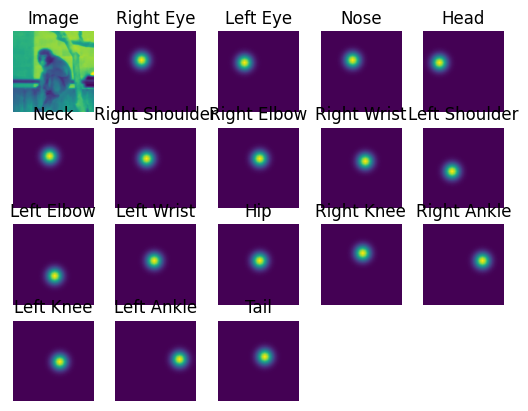

In [75]:
if __name__ == '__main__':
  #Config
  crop_size = 256
  batch_size = 32

#   Load in the data for training and/or validation
  data = Load_Data()

  #Create batches containing unique indexes expanding the length of our training set
  batches_x = create_batches(data, batch_size)

  #Grab the images from each batch containing unique indexes of training data
  train_images_batch, heat_images_batch, center_image_batch = get_batch_data(data, batches_x[0], crop_size)

  print(train_images_batch.shape) # (batch size, channels, height, width)
  print(heat_images_batch.shape)
  print(center_image_batch.shape)
  #print(center_image_batch[0][0])


  view_heat_maps(train_images_batch[0][0], heat_images_batch[0])


In [99]:
def view_heat_maps(img, heat_maps):
  Height, Width = img.shape[0], img.shape[1]

  heat_maps = np.transpose(heat_maps)

  dictionary_of_names = {0: 'Image', 1: 'Right Eye', 2: 'Left Eye', 3: 'Nose', 4: 'Head',
    5: 'Neck', 6: 'Right Shoulder', 7: 'Right Elbow', 8: 'Right Wrist', 9: 'Left Shoulder',
    10: 'Left Elbow', 11: 'Left Wrist', 12: 'Hip', 13: 'Right Knee', 14: 'Right Ankle',
    15: 'Left Knee', 16: 'Left Ankle', 17: 'Tail'}

  #print(heat_maps.shape)
  if(heat_maps.shape[0] != Height):
    heat_maps = transform.resize(heat_maps, (Height, Width))
  elif(heat_maps.shape[1] != Width):
    heat_maps = transform.resize(heat_maps, (Height, Width))

  for value in range((heat_maps.shape[2])): #256x256x18
    #print(value)
    plt.subplot(4, 5, value + 1)
    plt.title(dictionary_of_names[value], fontdict = {"fontsize" : 12})
    plt.axis("off")

    if value == 0:
      plt.imshow(img)
    else:
      plt.imshow(heat_maps[:, :, value - 1])
  plt.show()

torch.Size([1, 18, 256, 256])
(18, 32, 32)


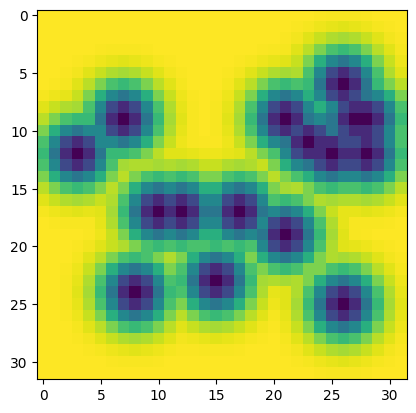

In [127]:
dir = os.path.join(dir_path, 'val_annotation.json')
with open(dir) as f:
    dictionary = json.load(f)
    features = [item for item in dictionary['data']]

f_d = features[7]

im_dir = os.path.join(dir_path, 'val', f_d['file'])
im = mpimg.imread(im_dir)
crop_size = 256
cm_size = (256, 256)
hm_size = (32, 32)

c_im, c_jts, c_cen = crop_image(im, f_d, crop_size)
hmaps, cmap = get_heatmap([np.zeros(hm_size), np.zeros(cm_size)], c_jts/8, c_cen)
c_im = np.transpose(c_im, (2, 0, 1))/255.0

pred = model(torch.from_numpy(np.expand_dims(c_im, axis=0)).float().to(device))
# print(pred.shape)
# plt.imshow(pred[0,:,:,:].cpu().detach().numpy())
# view_heat_maps(train_images_batch[0][0], heat_images_batch[0])
print(pred.shape)
print(hmaps.shape)

# plt.imshow(pred[0,:,:,:].cpu().detach().numpy())
# view_heat_maps(train_images_batch[0][0], pred[0,:,:,:])
#x_val[0-5,:,:,:].shape
x_val, y_val, x_val_center = get_batch_data(data_val, batch_test, crop_size)
x_val = np.rollaxis(x_val,1,4)

plt.imshow(hmaps[17,:,:])
# plt.imshow(pred[0, 17,:,:].cpu().detach().numpy())

# view_my_maps(np.moveaxis(x_val[6,:,:,:],0,2),pred[:,:,:,:])